In [1]:
from numpy import mean, std
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


## Load and check the image data

In [2]:
# load dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [3]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
train_X[0].shape

(28, 28)

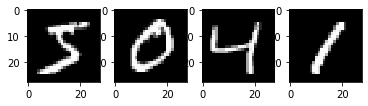

5 0 4 1


In [5]:
# plot 4 images as gray scale
plt.subplot(141)
plt.imshow(train_X[0], cmap=plt.get_cmap('gray'))
plt.subplot(142)
plt.imshow(train_X[1], cmap=plt.get_cmap('gray'))
plt.subplot(143)
plt.imshow(train_X[2], cmap=plt.get_cmap('gray'))
plt.subplot(144)
plt.imshow(train_X[3], cmap=plt.get_cmap('gray'))
plt.show()

print(train_y[0], train_y[1], train_y[2], train_y[3])

## Preprocessing the image data

In [6]:
# reshape dataset to have a single channel
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32')
test_X = test_X.reshape(test_X.shape[0], 28, 28, 1).astype('float32')

In [7]:
# normalize inputs from 0-255 to 0-1
train_X /= 255.0
test_X /= 255.0

In [8]:
# one hot encode outputs
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
num_classes = test_y.shape[1]

In [9]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


## Define a CNN model

In [11]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                100416    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total para

## Evaluate the model using k-fold cross-validation

In [12]:
# prepare cross validation
n_folds = 5
kfold = KFold(n_folds, shuffle=True, random_state=42)

acc -> 98.892
acc -> 99.425
acc -> 99.475
acc -> 99.975
acc -> 99.975
Accuracy: mean=99.548 std=0.404, n=5


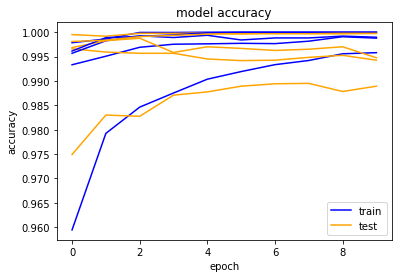

In [14]:
# enumerate splits
scores = list()
histories = list()

for train_ix, val_ix in kfold.split(train_X):
    
    # select rows for train and validation
    X_train, y_train, X_val, y_val = train_X[train_ix], train_y[train_ix], train_X[val_ix], train_y[val_ix]
    
    # fit model
    history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val), verbose=0)
    
    # evaluate model
    _, acc = model.evaluate(X_val, y_val, verbose=0)
    print('acc -> %.3f' % (acc * 100.0))
    
    # stores scores
    scores.append(acc)
    histories.append(history)
    
# print summary
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

# plot accuracy of the model
for i in range(len(histories)):
    plt.plot(histories[i].history['acc'], color='blue')
    plt.plot(histories[i].history['val_acc'], color='orange')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
plt.show()

## Save final model

In [15]:
# save model
model.save('cnn_mnist_final_model.h5')

## Evaluate final model

In [16]:
# load model
model = load_model('cnn_mnist_final_model.h5')

In [17]:
# evaluate model on test dataset
_, acc = model.evaluate(test_X, test_y, verbose=0)
print('Accuracy: %.3f' % (acc * 100.0))

Accuracy: 99.170


## Make Prediction

In [20]:
def load_image(filename):
    # load the image
    img = load_img(filename, color_mode="grayscale", target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img

In [21]:
# load the image
img = load_image('sample_image.png')

# predict the class
digit = model.predict_classes(img)
print(digit[0])

7
